![img](https://drive.google.com/uc?export=view&id=1kgX98Ziw9LzgBCT2BxChttfrTcBltLej)




##### **MÓDULO 4: APLICACIONES INFORMÁTICAS**

##### **Integrantes:**

- Carolina Castelvetri
- Consuelo Nuñez
- Jorge Sarrouf
- Lucas Gette
- Martin Boccardo


----

## **Objetivo**

A partir de la información obtenida de la **Central de Deudores del BCRA**, nuestro objetivo es realizar un análisis exhaustivo de las personas que se encuentran dentro del dataset y poder realizar un clustering en base a los tipos de personas, al género en caso de la personas físicas, al monto de deuda, al tipo de entidad que otorgó el crédito y a si la deuda se encuentra en default o no. De esta manera buscamos conformar distintos grupos de deudores que nos permitan realizar comparaciones interesantes y útiles entre los mismos.


## Dataset

Para la realización de este trabajo vamos a utilizar un conjunto de datos que componen la Central de Deudores del  Sistema  Financiero, provista por el [BCRA](http://www.bcra.gob.ar/BCRAyVos/Situacion_Crediticia.asp).

Los datos corresponden a información consolidada por clave de identificación fiscal (CUIT, CUIL o CDI) respecto de financiaciones otorgadas por entidades financieras, fideicomisos financieros, entidades no financieras emisoras de tarjetas de crédito / compra, otros proveedores no financieros de créditos, sociedades de garantía recíproca y fondos de garantía de carácter público y, además, cheques rechazados.



### Variables

| Nombre      | Descripción |
| ----------- | ----------- |
| **codigo_entidad**  | código de la entidad |      
| **fecha_informacion**    | año y mes |
| **cuit** | clave única de identificación tributaria |
| **situacion_deuda**   | 1 y 2 no es mora; 3 o más es mora |
| **credito**     | monto adeudado |
| **garan_otorgadas**   |  |
| **otros_conceptos**  |  |
| **garan_pref_auto_liq**   |  |
| **garan_pref**    |  |
| **c_garan_pref_auto_liq**    |  |
| **c_otr_gran_pref**    |  |


Nota: Los importes están expresados en miles de pesos con un decimal.


## Parte 1: Análisis y visualización

In [ ]:
#Librerías generales
import pandas as pd
import numpy as np
from numpy import mean, std
from pandas.api.types import is_numeric_dtype


In [ ]:
#Leemos el dataset
from google.colab import drive
drive.mount('/content/drive') 
df = pd.read_stata("/content/drive/MyDrive/TP4 - Grupo 10/BCRA202108.dta")
df.head(4) 

Mounted at /content/drive


,codigo_entidad,fecha_informacion,cuit,situacion_deuda,credito,garan_otorgadas,otros_conceptos,garan_pref_auto_liq,garan_pref,c_garan_pref_auto_liq,c_otr_gran_pref
0,7,202108,2.001815e+10,1,23,0,0,0,0,0,0
1,7,202108,2.001736e+10,1,6,0,0,0,0,0,0
2,7,202108,2.001677e+10,1,185,0,0,0,0,0,0
3,7,202108,2.000597e+10,1,201,0,0,0,0,0,0


In [ ]:
print(f'El set de datos contiene {df.shape[0]:,} filas y {df.shape[1]:,} columnas.')

El set de datos contiene 27,712,823 filas y 11 columnas.


El dataset contiene 10 características o features y la variable **situacion_deuda** que es nuestra variable objetivo. 

In [ ]:
df.columns.tolist()

['codigo_entidad',
 'fecha_informacion',
 'cuit',
 'situacion_deuda',
 'credito',
 'garan_otorgadas',
 'otros_conceptos',
 'garan_pref_auto_liq',
 'garan_pref',
 'c_garan_pref_auto_liq',
 'c_otr_gran_pref']

In [ ]:
#Información básica del dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27712823 entries, 0 to 27712822
Data columns (total 11 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   codigo_entidad         int32  
 1   fecha_informacion      int32  
 2   cuit                   float64
 3   situacion_deuda        int8   
 4   credito                int32  
 5   garan_otorgadas        int32  
 6   otros_conceptos        int32  
 7   garan_pref_auto_liq    int32  
 8   garan_pref             int32  
 9   c_garan_pref_auto_liq  int32  
 10  c_otr_gran_pref        int32  
dtypes: float64(1), int32(9), int8(1)
memory usage: 1.4 GB


In [ ]:
#Resumimos la cantidad de atributos de cada tipo
df.dtypes.value_counts()

int32      9
float64    1
int8       1
dtype: int64

Podemos ver que los datos son de tipo numérico:
* int8 e int32: valores numéricos enteros
* float64:   valores numéricos reales

Algunas celdas pueden estar codificadas con un tipo de dato no correcto, por ejemplo tipo float para el Cuit. También podemos estar en presencia de datos faltantes.

In [ ]:
#Visualizamos su estadistica descriptiva
df.describe()

,codigo_entidad,fecha_informacion,cuit,situacion_deuda,credito,garan_otorgadas,otros_conceptos,garan_pref_auto_liq,garan_pref,c_garan_pref_auto_liq,c_otr_gran_pref
count,2.771282e+07,2.771282e+07,2.771264e+07,2.771282e+07,2.771282e+07,2.771282e+07,2.771282e+07,2.771282e+07,2.771282e+07,2.771282e+07,2.771282e+07
mean,2.280977e+04,2.021080e+05,2.376405e+10,1.743988e+00,1.829726e+02,5.005858e+00,5.159526e+00,5.419818e+00,2.895848e+01,2.404680e-01,7.708424e-02
std,3.041873e+04,2.132295e-01,3.404231e+09,1.514063e+00,1.451817e+04,4.232894e+03,4.864758e+03,1.450520e+03,1.745435e+03,2.624301e+02,2.039704e+02
min,7.000000e+00,2.021060e+05,2.000000e+10,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.000000e+01,2.021080e+05,2.026729e+10,1.000000e+00,1.100000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.850000e+02,2.021080e+05,2.325384e+10,1.000000e+00,3.300000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,5.508500e+04,2.021080e+05,2.722293e+10,1.000000e+00,8.500000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,7.261600e+04,2.021080e+05,3.499926e+10,1.100000e+01,3.434360e+07,1.774468e+07,2.358251e+07,3.947556e+06,5.040029e+06,8.422820e+05,1.055718e+06


# Preprocesamiento de datos

In [ ]:
#Detección de las variables con datos faltantes
missing_values_count = df.isna().sum()
missing_values_count 

codigo_entidad             0
fecha_informacion          0
cuit                     179
situacion_deuda            0
credito                    0
garan_otorgadas            0
otros_conceptos            0
garan_pref_auto_liq        0
garan_pref                 0
c_garan_pref_auto_liq      0
c_otr_gran_pref            0
dtype: int64

Solo faltan 179 datos para la variable **cuit**. Y dada la cantidad total de observaciones, decidimos eliminar estos registros.


In [ ]:
#Eliminamos las filas con datos faltantes
df = df[df['cuit'].notna()]

Realizamos una descomposición de la variable **cuit** para poder identificar si se trata de empresas o personas físicas. En éste último caso poder identificar si se trata de hombres, mujeres o personas juridicas.

Como pudimos observar la variable **'cuit'** esta en formato float, por lo tanto vamos a castearla a string para poder descomponerla y poder determinar si se trata de una persona juridica o de una personal física, y en tal caso poder identificar el genero.

In [ ]:
#Casteamos la variable cuit de float a string
df['cuit'] = df['cuit'].astype(int).astype(str)

Agregamos nuevas variables identificando, según la codificación del cuit, si es empresa, hombre o mujer segun la siguiente tabla.

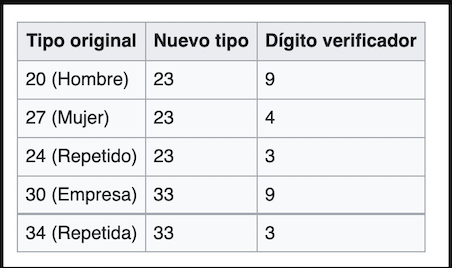

Fuente: https://es.wikipedia.org/wiki/Clave_%C3%9Anica_de_Identificaci%C3%B3n_Tributaria#Composici%C3%B3n

In [ ]:
#generamos columnas con los datos necesarios para distinguir entre Hombre, Mujer y Empresa
df.loc[:,['cuit_ini']] = df['cuit'].str.slice(0,2)
df.loc[:,['cuit_fin']] = df['cuit'].str.slice(10)

In [ ]:
df['cuit_ini'].value_counts()

20    12523040
27    12236121
23     2491906
30      307407
24      123481
33       30545
34         144
Name: cuit_ini, dtype: int64

Exploramos el Cuit 23 para saber con que digitos verificadores esta relacionado.

In [ ]:
df_23 = df.get(['cuit_ini','cuit_fin'])
df_23 = df_23[df['cuit_ini'] == '23']
df_23.groupby('cuit_fin').count()

,cuit_ini
cuit_fin,
0,261
1,263
2,258
3,12423
4,1224806
5,352
6,281
7,248
8,278


Se considerarán solo los cuit 23 con digito verificador 4 y 9, los otros no seran tomados en cuenta ya que no podremos identificar si son hombres o mujeres. Pero esto no sera un problema porque no es significante la cantidad de registros que contienen dichos dígitos.

Para el caso del cuit iniciado con el dígito 24 tampoco podemos identificar el género con la información que contamos. (analizar en el exploratorio el comportamiento de estos CUIT)


In [ ]:
df['mujer'] = np.where((df['cuit_ini']=='27') | ((df['cuit_ini']=='23') & (df['cuit_fin']=='4')), 1,0)
df['hombre'] = np.where((df['cuit_ini']=='20') | ((df['cuit_ini']=='23') & (df['cuit_fin']=='9')), 1,0)
df['empresa'] = np.where((df['cuit_ini']=='30') | (df['cuit_ini']=='33') | (df['cuit_ini']=='34'), 1,0)

df.drop(['cuit_ini','cuit_fin'],1, inplace = True)

In [ ]:
df['credito'].describe().round(3)

count    2.771264e+07
mean     1.809350e+02
std      1.305200e+04
min      0.000000e+00
25%      1.100000e+01
50%      3.300000e+01
75%      8.500000e+01
max      3.434360e+07
Name: credito, dtype: float64

Podemos observar del análisis descriptivo que el minimo para el monto del crédito es igual a 0, según la descripción de la base. Ésta contiene los deudores informados por las entidades financieras. Dado que esta variable está expresada en miles de pesos, podemos asumir que estos montos corresponden a deudas entre cero y mil pesos. Por lo tanto decidimos en estos casos reemplazar el 0 por un 1. De esta forma, los valores iguales a 1 indicarían deudas cuyos montos se encuentran dentro de ese rango.

Debido al amplio rango de valores en los que se mueve la variable deuda, consideramos que hacer este reemplazo no afectará nuestro análisis.

In [ ]:
# check deuda igual a  0
df_0 = df[df['credito'] == 0]
df_0 = df_0.groupby('situacion_deuda').size().sort_values(ascending = False).reset_index(name='counts')
df_0

,situacion_deuda,counts
0,5,1059468
1,1,12628
2,4,1173
3,3,103
4,2,56
5,11,54


In [ ]:
#Consideramos que la deuda 0, es menor a mil pesos, le ponemos 1 
df['credito'] = np.where(df['credito'] == 0, 1, df['credito'])

In [ ]:
#Controlamos que no queden deudas 0 de la info
df['credito'].isna().sum()

0

In [ ]:
#Columna "fecha_informacion"
print("Los datos registrados corresponden a los siguientes ", len(df.fecha_informacion.unique ()), "periodos:\n")
print(df.fecha_informacion.unique ())

Los datos registrados corresponden a los siguientes  3 periodos:

[202108 202107 202106]


In [ ]:
df["fecha_informacion"].value_counts()

202108    27255472
202106      274045
202107      183127
Name: fecha_informacion, dtype: int64

Observamos que la variable **'fecha_informacion'** presenta 3 etiquetas. La base contiene información de tres periodos, junio, julio y agosto del año 2021, donde la mayor catidad de registros se encuentra en el último periodo con una notable diferencia, lo que nos hace dudar si la información de los periodos anteriores está completa.

Hacemos un sample de 3 millones de cuits del período 08/2021 (el mas representativo) para evitar problemas de ram. 



In [ ]:
df = df[df['fecha_informacion']==202108]
df = df.merge(pd.DataFrame(df['cuit'].unique(), columns =['cuit']).sample(3000000),how='inner',on = 'cuit')

print(f'El set nuevo de datos contiene {df.shape[0]:,} filas y {df.shape[1]:,} columnas.')
print(f'Tenemos {df["cuit"].unique().shape[0]} clientes únicos')

El set nuevo de datos contiene 5,035,158 filas y 14 columnas.
Tenemos 3000000 clientes únicos


In [ ]:
#Visualizamos la cantidad de valores únicos de cada atributo
df.nunique().sort_values()

fecha_informacion              1
mujer                          2
hombre                         2
empresa                        2
situacion_deuda                6
c_garan_pref_auto_liq         91
c_otr_gran_pref              130
codigo_entidad               405
garan_otorgadas              943
otros_conceptos             1753
garan_pref_auto_liq         3007
garan_pref                  9302
credito                    14459
cuit                     3000000
dtype: int64

Creamos una nueva variable llamada '**garantías**' donde asignamos 1 a los créditos que fueron tomados con garantía y 0 a los que no presentaron garantías.

In [ ]:
# Generamos la nueva variable 'garantias'
 
df['garantias'] = np.where(((df['garan_otorgadas'] > 0) | 
                           (df['otros_conceptos'] > 0) |
                           (df['garan_pref_auto_liq'] > 0) | 
                           (df['garan_pref'] > 0) |
                           (df['c_garan_pref_auto_liq'] > 0) | 
                           (df['c_otr_gran_pref'] > 0 )), 1, 0)

df.drop(['garan_otorgadas'	,'otros_conceptos',	'garan_pref_auto_liq',	'garan_pref',	'c_garan_pref_auto_liq',	'c_otr_gran_pref'],1, inplace = True)

In [ ]:
#Observamos cuántos creditos hay sin garantía y con garantía
df['garantias'].value_counts()

0    4625855
1     409303
Name: garantias, dtype: int64

In [ ]:
deuda_original = df['credito'].sum()
print(f'Deuda del DF para control {deuda_original}')

Deuda del DF para control 959591401


La variable '**situación_deuda**' vimos que podía adoptar 6 valores posibles, los cuales representan un incumplimiento  en el pago en tiempo y forma según la siguiente información:

*  Situación 1: hasta 30 días
*  Situación 2: hasta 90 días
*  Situación 3: hasta 180 días
*  Situación 4: hasta 360 días
*  Situación 5: mas de 360 días
*  Situación 11: incobrables

Por convención se define que una deuda se considera en default si su situación de deuda es mayor a 2, por lo tanto simplicaficamos esta situación creando una nueva variable '**default**' indicando con un 1 si la deuda se encuentra en default y un 0 si no lo está.

In [ ]:
#Simplicamos si el cliente tiene default con la entidad

df['default'] = np.where(df['situacion_deuda'] > 2, 1,0)

df.drop(['situacion_deuda'],1, inplace = True)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5035158 entries, 0 to 5035157
Data columns (total 9 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   codigo_entidad     int32 
 1   fecha_informacion  int32 
 2   cuit               object
 3   credito            int32 
 4   mujer              int64 
 5   hombre             int64 
 6   empresa            int64 
 7   garantias          int64 
 8   default            int64 
dtypes: int32(3), int64(5), object(1)
memory usage: 326.5+ MB


In [ ]:
#adjuntamos informacion adicional al DF
df_tipo = pd.read_excel("/content/drive/MyDrive/TP4 - Grupo 10/codigos_entidades.xlsm", dtype = {'CODIGO': int,'nombre_entidad':str,'tipo_entidad' : int})

df = df.merge(df_tipo,how='left',left_on='codigo_entidad', right_on='CODIGO')

df.drop(['CODIGO','nombre_entidad'],1, inplace = True)

#tipo de entidad nulos los categorizamos con 6, sin dato
df['tipo_entidad'] = df['tipo_entidad'].fillna(6)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5035158 entries, 0 to 5035157
Data columns (total 10 columns):
 #   Column             Dtype  
---  ------             -----  
 0   codigo_entidad     int32  
 1   fecha_informacion  int32  
 2   cuit               object 
 3   credito            int32  
 4   mujer              int64  
 5   hombre             int64  
 6   empresa            int64  
 7   garantias          int64  
 8   default            int64  
 9   tipo_entidad       float64
dtypes: float64(1), int32(3), int64(5), object(1)
memory usage: 364.9+ MB


In [ ]:
df.sample(5)

,codigo_entidad,fecha_informacion,cuit,credito,mujer,hombre,empresa,garantias,default,tipo_entidad
2529413,34,202108,27303242428,55,1,0,0,0,0,1.0
1318229,14,202108,27036989721,35,1,0,0,0,0,1.0
997430,11,202108,27126972569,85,1,0,0,0,0,1.0
4146432,386,202108,27056796210,17,1,0,0,0,1,1.0
738648,72113,202108,20170753942,22,0,1,0,0,0,5.0


In [ ]:
#generamos informacion para anexar despues
#mujer, hombre, emrpesa, garantias y cantidad de defaults
df_info = df.groupby(['fecha_informacion','cuit']).garantias.max().to_frame().reset_index()
df_info2 = df.groupby(['fecha_informacion','cuit','mujer','empresa','hombre']).default.sum().to_frame().reset_index()

In [ ]:
#agrupamos DF por tipo de entidad de cada cliente
df = df.groupby(['fecha_informacion','cuit','mujer','hombre','empresa','default','tipo_entidad']).credito.sum().reset_index()

In [ ]:
df.head()

,fecha_informacion,cuit,mujer,hombre,empresa,default,tipo_entidad,credito
0,202108,20000143368,0,1,0,0,1.0,11
1,202108,20000147541,0,1,0,1,2.0,9
2,202108,20001509803,0,1,0,1,1.0,6
3,202108,20002173353,0,1,0,1,1.0,8
4,202108,20002404444,0,1,0,0,3.0,75


In [ ]:
# agregamos una marca simple de default 
df['ok'] = np.where(df['default'] >= 1 , 0,1)

In [ ]:
df.head()

,fecha_informacion,cuit,mujer,hombre,empresa,default,tipo_entidad,credito,ok
0,202108,20000143368,0,1,0,0,1.0,11,1
1,202108,20000147541,0,1,0,1,2.0,9,0
2,202108,20001509803,0,1,0,1,1.0,6,0
3,202108,20002173353,0,1,0,1,1.0,8,0
4,202108,20002404444,0,1,0,0,3.0,75,1


In [ ]:
df = df.pivot_table(values = ['credito'], index=['fecha_informacion', 'cuit'],
                    columns=['ok','tipo_entidad'], aggfunc=np.sum, fill_value=0).reset_index().set_axis(['fecha_informacion', 'cuit', 'E1_D', 'E2_D', 'E3_D','E4_D','E5_D','E6_D','E1_Ok', 'E2_Ok', 'E3_Ok','E4_Ok','E5_Ok','E6_Ok'], axis=1)

In [ ]:
df[df['cuit']== '20000297713']

,fecha_informacion,cuit,E1_D,E2_D,E3_D,E4_D,E5_D,E6_D,E1_Ok,E2_Ok,E3_Ok,E4_Ok,E5_Ok,E6_Ok


In [ ]:
df.head()

,fecha_informacion,cuit,E1_D,E2_D,E3_D,E4_D,E5_D,E6_D,E1_Ok,E2_Ok,E3_Ok,E4_Ok,E5_Ok,E6_Ok
0,202108,20000143368,0,0,0,0,0,0,11,0,0,0,0,0
1,202108,20000147541,0,9,0,0,0,0,0,0,0,0,0,0
2,202108,20001509803,6,0,0,0,0,0,0,0,0,0,0,0
3,202108,20002173353,8,0,0,0,0,0,0,0,0,0,0,0
4,202108,20002404444,0,0,0,0,0,0,0,0,75,0,0,0


In [ ]:
 #Agregamos info del tipo y cliente y cantidad de empresas con default
df = df.merge(df_info,how='inner',left_on = ['cuit','fecha_informacion'],right_on = ['cuit','fecha_informacion'])
df = df.merge(df_info2,how='inner',left_on = ['cuit','fecha_informacion'],right_on = ['cuit','fecha_informacion'])
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3000000 entries, 0 to 2999999
Data columns (total 19 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   fecha_informacion  int64 
 1   cuit               object
 2   E1_D               int64 
 3   E2_D               int64 
 4   E3_D               int64 
 5   E4_D               int64 
 6   E5_D               int64 
 7   E6_D               int64 
 8   E1_Ok              int64 
 9   E2_Ok              int64 
 10  E3_Ok              int64 
 11  E4_Ok              int64 
 12  E5_Ok              int64 
 13  E6_Ok              int64 
 14  garantias          int64 
 15  mujer              int64 
 16  empresa            int64 
 17  hombre             int64 
 18  default            int64 
dtypes: int64(18), object(1)
memory usage: 457.8+ MB


In [ ]:
#generamos columnas con informacion extra
df['deuda_total'] = df['E1_Ok'] + df['E2_Ok'] +df['E3_Ok'] +df['E4_Ok'] +df['E5_Ok'] +df['E6_Ok'] + df['E1_D'] + df['E2_D'] +df['E3_D'] +df['E4_D'] +df['E5_D'] +df['E6_D']
df['deuda_default'] = np.where(df['default'] == 0, 0, df['deuda_total'])
df['deuda_ok'] = np.where(df['default'] == 0, df['deuda_total'],0 )

df.head()

,fecha_informacion,cuit,E1_D,E2_D,E3_D,E4_D,E5_D,E6_D,E1_Ok,E2_Ok,E3_Ok,E4_Ok,E5_Ok,E6_Ok,garantias,mujer,empresa,hombre,default,deuda_total,deuda_default,deuda_ok
0,202108,20000143368,0,0,0,0,0,0,11,0,0,0,0,0,0,0,0,1,0,11,0,11
1,202108,20000147541,0,9,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,9,9,0
2,202108,20001509803,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,6,6,0
3,202108,20002173353,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,8,8,0
4,202108,20002404444,0,0,0,0,0,0,0,0,75,0,0,0,0,0,0,1,0,75,0,75


In [ ]:
print(f'Deuda original {deuda_original} , Deuda_archivo procesado {df["deuda_total"].sum()} ')

Deuda original 959591401 , Deuda_archivo procesado 959591401 


In [ ]:
#Detección de las variables con datos faltantes
missing_values_count = df.isna().sum()
missing_values_count 

fecha_informacion    0
cuit                 0
E1_D                 0
E2_D                 0
E3_D                 0
E4_D                 0
E5_D                 0
E6_D                 0
E1_Ok                0
E2_Ok                0
E3_Ok                0
E4_Ok                0
E5_Ok                0
E6_Ok                0
garantias            0
mujer                0
empresa              0
hombre               0
default              0
deuda_total          0
deuda_default        0
deuda_ok             0
dtype: int64

In [ ]:
# Correr esto para generar y bajar el archivo
from google.colab import files
df.to_csv('bcra_procesado.csv',index=False)


In [ ]:
#esto para descargar
#files.download("test.csv")

In [ ]:
#descargar directamente a drive. MUCHO MAS RAPIDO
!cp bcra_procesado.csv "/content/drive/My Drive/"